# Installing Julia 1.3

In [7]:
# Installation cell
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Load Packages

In [32]:
#Julia 1.3 Environment
using Pkg
pkg"add BenchmarkTools; precompile;"
pkg"add CuArrays; precompile;"
pkg"add Plots; precompile;"
pkg"add Flux; precompile;"
pkg"add Images; precompile;"
pkg"add Interact; precompile;"
pkg"add JLD2; precompile;"
pkg"add IterTools; precompile;"
Pkg"add BSON; precompile;"

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [a09fc81d] ↑ ImageCore v0.8.12 ⇒ v0.8.21
  [dbb5928d] ↑ MappedArrays v0.2.2 ⇒ v0.3.0
  [e94cdb99] + MosaicViews v0.2.4
Precompiling project...
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
Precompiling project...
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
Precompiling project...
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
Precompiling project...
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v

LoadError: ignored

In [33]:
using Plots, Images, Interact, JLD2, Flux
using Flux: onehotbatch, argmax, crossentropy, throttle, mse, onecold, shuffle
using Flux.Data: DataLoader
using IterTools: ncycle, partition
using Statistics: mean

theme(
    :wong;
    format=:png,
    label="",
    markerstrokewidth=0.3,
    markerstrokecolor="white",
    markersize=6,
    alpha=0.7
)


# Load Data



In [23]:
X_rock = load("rock.jld2")["rock_imgs"]
X_paper = load("paper.jld2")["paper_imgs"]
X_scissors = load("scissors.jld2")["scissors_imgs"];


# Preprocessing



In [24]:
function array2matrix(X::AbstractArray{T, 4}) where T
    height, width, rgb, n_samples = size(X)

    Y = zeros(height * width * rgb, n_samples)

    for idx in 1:n_samples
        Y[:, idx] = vec(X[:, :, :, idx])
    end

    return Y
end

array2matrix (generic function with 1 method)

In [25]:
using Random: randperm, seed!

function split_train_test(X::AbstractArray, train_fraction::Float64, sample_dim::Int64=ndims(X); seed::Integer=1)
    n_samples = size(X, sample_dim)
    n_train = round(Integer, n_samples * train_fraction)

    rand_idx = randperm(seed!(seed), n_samples)
    train_idx = rand_idx[1:n_train]
    test_idx = rand_idx[(n_train + 1):end]

    X_train = selectdim(X, sample_dim, train_idx)
    X_test = selectdim(X, sample_dim, test_idx)

    return X_train, X_test
end

split_train_test (generic function with 2 methods)

In [26]:
n_samples = size(X_rock, 4)
train_fraction = 0.6
X_rock_vec = array2matrix(X_rock)
X_paper_vec = array2matrix(X_paper)
X_scissors_vec = array2matrix(X_scissors)
X_train_rock, X_test_rock = split_train_test(X_rock_vec, train_fraction)
X_train_paper, X_test_paper = split_train_test(X_paper_vec, train_fraction)
X_train_scissors, X_test_scissors = split_train_test(X_scissors_vec, train_fraction)

X_train = hcat(X_train_rock, X_train_paper, X_train_scissors)
X_test = hcat(X_test_rock, X_test_paper, X_test_scissors)

labels_train = vcat(
  ones(size(X_train_rock, 2)),
  ones(size(X_train_paper, 2)) * 2,
  ones(size(X_train_scissors, 2)) * 3
)

@show size(labels_train)

Y_train = onehotbatch(Int64.(labels_train), 1:3)

labels_test = vcat(
  ones(size(X_test_rock, 2)),
  ones(size(X_test_paper, 2)) * 2,
  ones(size(X_test_scissors, 2)) * 3
)

@show size(labels_test)

Y_test = onehotbatch(Int64.(labels_test), 1:3)

@show size(X_train)
@show size(X_test)
@show size(Y_train)
@show size(Y_test)



size(labels_train) = (1278,)
size(labels_test) = (852,)
size(X_train) = (7200, 1278)
size(X_test) = (7200, 852)
size(Y_train) = (3, 1278)
size(Y_test) = (3, 852)


(3, 852)

# Training

In [27]:
num_nodes = 250
m = Chain(
    Dense(7200, num_nodes, relu),
    Dense(num_nodes, num_nodes, relu),
    Dense(num_nodes, num_nodes, relu),
    Dense(num_nodes, num_nodes, relu),
    Dense(num_nodes, 3, relu),
    softmax
)

using BSON: @save
@save "model.bson" m

loss(x, y) = crossentropy(m(x), y) 
accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

@show loss(X_train, Y_train)
@show accuracy(X_train, Y_train)

opt = ADAM(1e-4);

function evalcb()
    l = round(loss(X_train, Y_train); digits=4)
    a = round(accuracy(X_train, Y_train); digits=4)
    println("Loss: $(l)\tAccuracy: $(a)")
end

batchsize = 100
epochs = 50 

train_loader = DataLoader(X_train, Y_train; batchsize=batchsize, shuffle=true)
Flux.train!(loss, params(m), ncycle(train_loader, epochs), opt; cb=throttle(evalcb, 2.0))

test_accuracy = accuracy(X_test, Y_test)
println("Test accuracy is $(test_accuracy)")

loss(X_train, Y_train) = 1.106476f0
accuracy(X_train, Y_train) = 0.30359937402190923
Loss: 1.1024	Accuracy: 0.3341
Loss: 1.0215	Accuracy: 0.4742
Loss: 0.9987	Accuracy: 0.4077
Loss: 0.8956	Accuracy: 0.5962
Loss: 0.8522	Accuracy: 0.6972
Loss: 0.8277	Accuracy: 0.7089
Loss: 0.7913	Accuracy: 0.7833
Loss: 0.748	Accuracy: 0.741
Loss: 0.7309	Accuracy: 0.7402
Loss: 0.6935	Accuracy: 0.7746
Loss: 0.6748	Accuracy: 0.8059
Loss: 0.7388	Accuracy: 0.6909
Loss: 0.6754	Accuracy: 0.7285
Loss: 0.643	Accuracy: 0.8279
Loss: 0.6172	Accuracy: 0.8717
Loss: 0.6222	Accuracy: 0.8599
Loss: 0.5874	Accuracy: 0.8302
Loss: 0.5712	Accuracy: 0.8631
Loss: 0.5637	Accuracy: 0.8365
Loss: 0.5796	Accuracy: 0.9272
Loss: 0.5316	Accuracy: 0.8826
Loss: 0.5378	Accuracy: 0.8678
Loss: 0.5173	Accuracy: 0.9178
Loss: 0.5116	Accuracy: 0.9272
Loss: 0.5059	Accuracy: 0.8623
Loss: 0.494	Accuracy: 0.9225
Loss: 0.5008	Accuracy: 0.9523
Loss: 0.4786	Accuracy: 0.9092
Loss: 0.4801	Accuracy: 0.8959
Loss: 0.4794	Accuracy: 0.8834
Loss: 0.4677	Accura

# Evaluation

Load Model

In [21]:
using BSON: @load
using JLD
@load "my_deep_rps_model.bson" m

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
 Installed HDF5_jll ──── v1.12.0+1
 Installed JLD ───────── v0.12.3
 Installed Lz4_jll ───── v1.9.2+2
 Installed Zstd_jll ──── v1.4.8+0
 Installed LibCURL_jll ─ v7.70.0+2
 Installed nghttp2_jll ─ v1.40.0+2
 Installed HDF5 ──────── v0.15.4
 Installed Blosc ─────── v0.7.0
 Installed Blosc_jll ─── v1.14.3+1
 Installed LibSSH2_jll ─ v1.9.0+3
  Updating `~/.julia/environments/v1.3/Project.toml`
  [4138dd39] + JLD v0.12.3
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [a74b3585] + Blosc v0.7.0
  [0b7ba130] + Blosc_jll v1.14.3+1
  [34da2185] + Compat v3.27.0
  [f67ccb44] + HDF5 v0.15.4
  [0234f1f7] + HDF5_jll v1.12.0+1
  [a09fc81d] ↓ ImageCore v0.8.21 ⇒ v0.8.12
  [4138dd39] + JLD v0.12.3
  [deac9b47] + LibCURL_jll v7.70.0+2
  [29816b5a] + LibSSH2_jll v1.9.0+3
  [5ced341a] + Lz4_jll v1.9.2+2

┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1273
┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/root/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl", 162, UndefVarError(:HDF5Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007fb093c6cc3b, Ptr{Nothing} @0x00007fb093c46004, Ptr{Nothing} @0x00007fb093c14240, Ptr{Nothing} @0x00007fb093da2faf, Ptr{Nothing} @0x00007fb093da35de, Ptr{Nothing} @0x00007fb093da3250, Ptr{Nothing} @0x00007fb093da3d84, Ptr{Nothing} @0x00007fb093da458f, Base.InterpreterIP(CodeInfo(
    @ /root/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:162 within `top-level scope'
1 ─      $(Expr(:thunk, CodeInfo(
    @ none within `top-level scope'
1 ─     return $(Expr(:method, :_write_datatype_attr))
)))
│        $(Expr(:method, :_write_datatype_attr))
│   %3 = Core.TypeVar(:T)
│   %4 = Core.Typeof(_write_datatype_attr)
│   %5 = Core.apply_type(Union, HDF5Group, HDF5Dataset)
│   %6 = Cor

ArgumentError: ignored

Compute Confusion Matrix

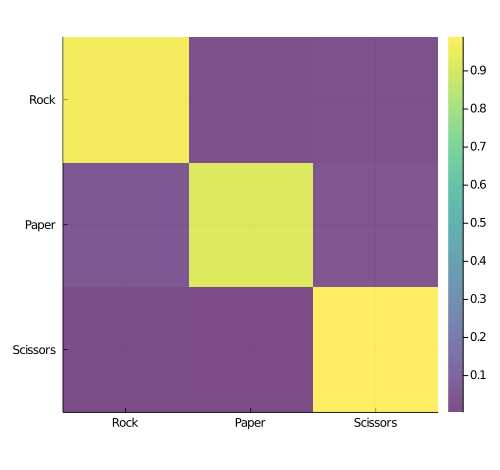

In [36]:
Y_out = m(X_test)

test_predicted = onecold(Y_out)
test_actual = onecold(Y_test)

confusion_matrix = zeros(3, 3)
for i in 1:3
    indices_i = findall(test_actual .== i)
    
    # predictions for class i
    predictions_i = test_predicted[indices_i]
    
    for j in 1:3
        # fraction of class i samples labeled as class j
        confusion_matrix[i, j] = sum(predictions_i .== j) / length(indices_i)
    end
end

heatmap(
    confusion_matrix;
    aspect_ratio=1.0,
    yflip=true,
    xticks=(collect(1:3), ["Rock", "Paper", "Scissors"]),
    yticks=(collect(1:3), ["Rock", "Paper", "Scissors"]),
    size=(500, 470)
)

In [29]:
@show confusion_matrix

confusion_matrix = [0.9647887323943662 0.014084507042253521 0.02112676056338028; 0.04225352112676056 0.9190140845070423 0.03873239436619718; 0.007042253521126761 0.0035211267605633804 0.9894366197183099]


3×3 Array{Float64,2}:
 0.964789    0.0140845   0.0211268
 0.0422535   0.919014    0.0387324
 0.00704225  0.00352113  0.989437 

# Comparison with GPU



In [40]:
pkg"add CuArrays; precompile;"

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
Precompiling project...


In [48]:
using BenchmarkTools
using CuArrays

CuArrays.allowscalar(false)

m2 = Chain(
    Dense(7200, num_nodes, relu),
    Dense(num_nodes, num_nodes, relu),
    Dense(num_nodes, num_nodes, relu),
    Dense(num_nodes, num_nodes, relu),
    Dense(num_nodes, 3, relu),
    softmax
) |> gpu

X_train2 = X_train |> gpu
Y_train2 = Y_train |> gpu

loss2(x, y) = crossentropy(m2(x), y) 
accuracy2(x, y) = mean(onecold(m2(x) |> cpu) .== onecold(y |> cpu))
function evalcb2()
    l = round(loss2(X_train2, Y_train2); digits=4)
    a = round(accuracy2(X_train2, Y_train2); digits=4)
    println("Loss: $(l)\tAccuracy: $(a)")
end

train_loader2 = DataLoader(X_train2, Y_train2; batchsize=batchsize, shuffle=true)
@benchmark Flux.train!(loss2, params(m2), ncycle(train_loader2, epochs), opt; cb=throttle(evalcb2, 2.0))


Loss: 1.1148	Accuracy: 0.3333
Loss: 0.8145	Accuracy: 0.3333
Loss: 0.7854	Accuracy: 0.3333
Loss: 0.7481	Accuracy: 0.3333
Loss: 0.7462	Accuracy: 0.3333
Loss: 0.7431	Accuracy: 0.3333
Loss: 0.7424	Accuracy: 0.3333
Loss: 0.753	Accuracy: 0.3333
Loss: 0.74	Accuracy: 0.3333
Loss: 0.7414	Accuracy: 0.3333
Loss: 0.7408	Accuracy: 0.3333
Loss: 0.7768	Accuracy: 0.3333
Loss: 0.7434	Accuracy: 0.3333
Loss: 0.7375	Accuracy: 0.3333
Loss: 0.7362	Accuracy: 0.3333
Loss: 0.7361	Accuracy: 0.3333


BenchmarkTools.Trial: 
  memory estimate:  221.81 MiB
  allocs estimate:  5635959
  --------------
  minimum time:     7.046 s (0.73% GC)
  median time:      7.046 s (0.73% GC)
  mean time:        7.046 s (0.73% GC)
  maximum time:     7.046 s (0.73% GC)
  --------------
  samples:          1
  evals/sample:     1

In [44]:
@benchmark Flux.train!(loss, params(m), ncycle(train_loader, epochs), opt)

BenchmarkTools.Trial: 
  memory estimate:  61.96 GiB
  allocs estimate:  2301574461
  --------------
  minimum time:     207.672 s (3.07% GC)
  median time:      207.672 s (3.07% GC)
  mean time:        207.672 s (3.07% GC)
  maximum time:     207.672 s (3.07% GC)
  --------------
  samples:          1
  evals/sample:     1